# CE4021 Group Project

## Group 2.2

## Student Name: Mark Murnane
## Student ID: 18195326

## Problem Description

Given a dataset describing empirical qualities of a wine (e.g. acidity, sugar levels) analyze the data using a Multi-Layer Perceptron Neural Network to build a classifier of the wine's quality.  The quality of the wine is described in the data set as a integer value from 1-10, making it appropriate for classification.

### Data Set Origin

The data set has been sourced from the University of California, Irvine's (UCI) Machine Learning Repository ([link](http://archive.ics.uci.edu/ml/index.php)).  The data was made available in support of a data mining approach for wine quality described in (Cortez _et al._, 2009).  

The data set for red wine was downloaded from [Kaggle](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009), but can be found in the UCI archive [here](https://archive.ics.uci.edu/ml/datasets/wine+quality).  A combined data set is available from  Paulo Cortez's [website](http://www3.dsi.uminho.pt/pcortez/wine/).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import pipeline

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

### Data Import

The data set is read from a CSV using the Pandas framework to yield a Pandas data frame.  As the data set is complete and does not need any gaps to be inferred/replaced, then the feature and target data can be extracted to _numpy_ arrays for use by the _scikit-learn_ models.

In [2]:
# Data Import
wine_source = pd.read_csv('winequality-red.csv', header=0, )

wine_source.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
wine_data = wine_source.values[:,:-1]
wine_target = wine_source.values[:,-1]

### Pre-processing

The data set contains 11 features which combine to provide the output.  For many of the features in the data set, the variance is relatively low (e.g. density which approximate to 1).  As a simple way to explore how to tackle the data set it's worth establishing any dominant features.  Equally some features (such as density) will play next to no part in discriminating the results.

The determine if this is the case, and if so what to include/remove, we'll use PCA to identify the most important components.

The data set is complete and has no missing elements that need to be adjusted for.

The features have different scales, however, often an order of magnitude apart.  To avoid larger numeric variances from dominating the PCA algorithm, the data will be normailsed before PCA or model processing.

_outlier detection would have to take place before this_

_Make sure to check for direction.  May need to reshape the matrix_

#### Validate that the data set is complete

In [4]:
## TODO: Insert some code here

#### Handle the target

While the range of the target values is 0 to 10, the data set actually as a smaller range.

In [5]:
print(wine_source["quality"].min())
print(wine_source["quality"].max())

3
8


As some initial testing of the training data suggested difficulty resolving the model, reclassifying the quality as either "Poor", "Normal", "Improved".

In [6]:
def convert_target_quality(target):
    new_target = 0
    
    if target > 6:
        new_target =  2
    elif target > 4:
        new_target = 1
    else:
        new_target = 0
        
    return new_target

new_wine_target = np.array([convert_target_quality(x) for x in wine_target])


#### PCA on the full data set


While in many examples the data is split into a test and training sets ahead of PCA, as the sample size is relatively small, I'll first perform a PCA analysis on the full set.  This will give a more comprehensive view of the data set

In [7]:
np.set_printoptions(formatter={'float': '{: 0.6f}'.format})

# Do some data cleansing/pre-processing
# The data set seems pretty clean so little to do here

# 1. Normalisation
wine_data_std  = preprocessing.scale(wine_data, axis=0)

# 2. Do a PCA analysis to determine which variables appear to be relatively more important than others
pca_full = PCA()
pca_full.fit(wine_data_std)

full_variance_ratio = pca_full.explained_variance_ratio_*100
full_cumulative_vr = np.cumsum(full_variance_ratio)

Plotting the contribution of the principal components to the variance of the total data set might indicate how many features of this data set are significant.

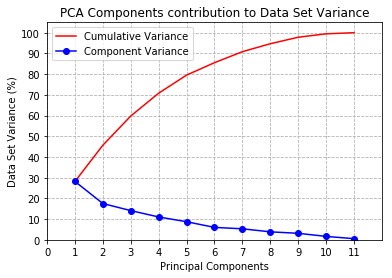

In [8]:
def plot_pca_variance (cumulative_variance_data, variance_data, components = 11, max_percentage = 100, percent_steps = 10):
    # Titles
    plt.title("PCA Components contribution to Data Set Variance")
    plt.xlabel("Principal Components")
    plt.ylabel("Data Set Variance (%)")

    # Set boundaries and assert ticks for each components
    # Increase the x and y limits by a margin so that the graph doesn't abut the boundaries
    plt.xlim(0, components + 1)
    plt.ylim(0, max_percentage + 5)
    plt.xticks(range(0, components + 1))
    plt.yticks(range(0, max_percentage + 5, percent_steps))

    # Grid for ease of reading
    plt.grid(True, linestyle='--')
    
    plt.plot(range(1, components + 1), cumulative_variance_data, label="Cumulative Variance", color="r")
    plt.plot(range(1, components + 1), variance_data, label="Component Variance", color="b", marker="o")
    
    plt.legend()
    plt.show()
    
plot_pca_variance(full_cumulative_vr, full_variance_ratio)

The fact that the curve is relatively shallow - there is no real **_elbow_** - indicates that no one feature is highly dominant in the data set.  This may be because the wines (_vinho verde_) described all originate from the same region (the north of Portugal) and are generally consumed relatively soon after bottling.  As a result there may be insufficient variety in the environment and production methods to influence the wine itself.

Looking at the graph above the majority of the data set, the minimum number of components to reduce to would be 5, giving approximately 80% coverage.  Selecting the first 7 components gives over 90% coverage and would be a better choice.  

This might also indicate that while the remaining values don't contribute significantly, there may not be significant value in removing them from the data set.


### Test and Training Data

The Machine Learner requires both _Training_ and _Test_ data.  As with the analysis above, the split data sets need to be normalised, and specifically the _Test_ data needs to be normalised with the same values as the _Training_ set. 

To simplify the process, a **_Pipeline_** can be used to ensure that the values are correctly applied form one stage to the next without needing any specific coding.

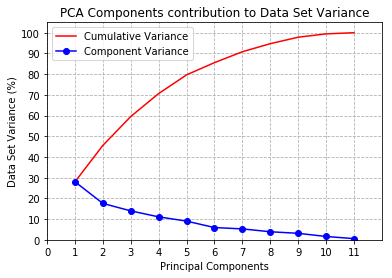

Is the variance of the training data almost the same (+/- 0.5%) as the full data? True


In [9]:
wine_data_train, wine_data_test, wine_target_train, wine_target_test = train_test_split(wine_data, new_wine_target, test_size=0.2, random_state=42)

# TODO: Here's where we do cross validation

# Now construct the Pipline for scaling and PCA
pline = pipeline.make_pipeline(preprocessing.StandardScaler(), PCA())
pline.fit(wine_data_train, wine_target_train)

training_pca = pline.named_steps['pca']

training_variance_ratio = training_pca.explained_variance_ratio_*100
training_cumulative_vr = np.cumsum(training_variance_ratio)

plot_pca_variance(training_cumulative_vr, training_variance_ratio)

print(f"Is the variance of the training data almost the same (+/- 0.5%) as the full data? {np.allclose(full_variance_ratio, training_variance_ratio, atol=0.5)}")

### MLP Classifier

Now that the data has been normalised it's time to build the classificationn model.

For the model, we'll use RELU as the activation function for the Neural Network.  The 3Blue1Brown series indicated strongly that ReLU is preferred over the Sigmoid Function as it tends to a result.  For a data set this size, it may not make of a difference, however.

For the initial attempt we'll use _adam_ as the solver.  The scikit-learn examples include a [Comparison of Stochastic learning strategies](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html#sphx-glr-auto-examples-neural-networks-plot-mlp-training-curves-py) that show _adam_ quickly converges towards minima across a number of different data sets.

Based on the work above, for this step we'll create a new pipeline that involves that:

* Normalises the data
* Uses PCA to reduce the number of components to 7
* Executes the MLPClassifier

In [40]:
#mlp_net = MLPClassifier(hidden_layer_sizes=(10,10), activation='relu', solver='adam', batch_size=20, shuffle=True, verbose=False, random_state=42)
mlp_net = MLPClassifier(hidden_layer_sizes=(10,10), activation='relu', solver='lbfgs', verbose=True, random_state=42)

model_pipe = pipeline.make_pipeline(preprocessing.StandardScaler(), PCA(n_components=7), mlp_net)

model_pipe.fit(wine_data_train, wine_target_train)

train_score = model_pipe.score(wine_data_train, wine_target_train)
test_score = model_pipe.score(wine_data_test, wine_target_test)

print(f"Training set score:\t{train_score:.3f}")
print(f"Test set score:\t\t{test_score:.3f}")

Training set score:	0.894
Test set score:		0.834


### Model Visualisation

<TODO> Need to figure out what's viable here.  With the high dimensionality, plotting could be difficult.

## Reference List

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.